# Day-to-day evolution of supply and demand
Module for simulating ridesourcing evolution

Contribution by Arjan de Ruijter - a.j.f.deruijter@tudelft.nl

In [1]:
%load_ext autoreload
%autoreload 2
import os, sys # add MaaSSim and MaaSSim/MaaSSim to path (not needed if already in path)
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from MaaSSim.utils import save_config, get_config, load_G, generate_demand, initialize_df, empty_series, \
    slice_space, test_space
from MaaSSim.maassim import Simulator
from MaaSSim.data_structures import structures as inData
from MaaSSim.d2d import *
from MaaSSim.shared import prep_shared_rides

In [3]:
import pandas as pd
import logging
import matplotlib.pyplot as plt

In [4]:
# Load config
params = get_config('../../data/config/delft.json')  # load configuration

In [5]:
# Experiment replications and number of threads to be used
params.parallel.nReplications = 1
params.parallel.nThread = 3

# Main experimental settings
params.nP = 200 # travellers
params.nV = 5 # drivers
params.nD = 5 # days
params.simTime = 8 # hours

params.demand_structure.destinations_dispertion = -0.0003

In [6]:
# Other day-to-day settings
params.evol.drivers.omega = 5 # recency: until this day perfect memory, afterwards weight 1/recency for last experience
params.evol.drivers.res_wage.mean = 80 #euros
params.evol.drivers.res_wage.std = 20 #euros
params.evol.drivers.init_inc_ratio = 1 #expected income of informed drivers at start of sim as ratio of res wage

params.evol.drivers.inform.prob_start = 1 # probability of being informed at start of sim
params.evol.drivers.inform.beta = 0.2 # information transmission rate

params.evol.drivers.regist.prob_start = 1 # probability of being registered if informed at start of sim
params.evol.drivers.regist.beta = 0.2 # registration choice model parameter
params.evol.drivers.regist.cost_comp = 20 # daily share of registration costs (euros)
params.evol.drivers.regist.samp = 0.2 # probability of making regist decision when informed (and unregistered)

params.evol.drivers.particip.beta = 0.1 # participation choice model parameter
params.evol.drivers.particip.probabilistic = True # stochasticity in participation choice

# params.evol.min_it = 10 # minimum number of days in simulation
# params.evol.conv = 0.005 # convergence criterion, currently not in use

# Financial settings
params.platforms.base_fare = 1.4 #euro
params.platforms.fare = 1.21 #euro/km
params.platforms.min_fare = 0 # euro
params.platforms.comm_rate = 0.25 #rate
params.drivers.fuel_costs = 0.25 #euro/km

# Demand settings
# params.min_dist = 2 # minimum OD distance when creating requests
# params.max_dist = 30 # maximum OD distance

# Start time
params.t0 = pd.Timestamp.now()

In [7]:
inData = load_G(inData, params, stats=True)  # download graph for the 'params.city' and calc the skim matrices
inData = generate_demand(inData, params, avg_speed = False)
fixed_supply = generate_vehicles_d2d(inData, params)
inData.vehicles = fixed_supply.copy()
inData.vehicles.platform = inData.vehicles.apply(lambda x: 0, axis = 1)
inData.passengers.platforms = inData.passengers.apply(lambda x: [0], axis = 1)
inData.requests['platform'] = inData.requests.apply(lambda row: inData.passengers.loc[row.name].platforms[0], axis = 1) 
inData.platforms = pd.concat([inData.platforms,pd.DataFrame(columns=['base_fare','comm_rate','min_fare'])])
inData.platforms = initialize_df(inData.platforms)
inData.platforms.loc[0]=[params.platforms.fare,'Uber',30,params.platforms.base_fare,params.platforms.comm_rate,params.platforms.min_fare,]

inData = prep_shared_rides(inData, params.shareability)  # prepare schedules

In [25]:
d2d = DotMap()
d2d.drivers = dict()
d2d.travs = dict()
sim = Simulator(inData, params=params,
                    kpi_veh = D2D_veh_exp,
                    f_driver_out = D2D_driver_out,
                    f_trav_mode = pax_mode_choice,
                    logger_level=logging.WARNING)  # initialize

for day in range(params.get('nD', 1)):  # run iterations
    sim.make_and_run(run_id=day)  # prepare and SIM
    sim.output()  # calc results

    d2d.drivers[day] = update_d2d_drivers(sim=sim,params=params)
    d2d.travs[day] = update_d2d_travellers()
    res_inf = word_of_mouth(inData, params = params)
    inData.vehicles.informed = res_inf
    res_regist = platform_regist(inData, d2d.drivers[day], params = params)
    inData.vehicles.registered = res_regist.registered
    inData.vehicles.expected_income = res_regist.expected_income
    inData.vehicles.pos = fixed_supply.pos

evol_micro, evol_stats = D2D_summary(drivers = d2d.drivers) # multi-day stats

15-12-20 18:27:38-WARNING-Setting up 8h simulation at 2020-12-15 11:40:01 for 5 vehicles and 200 passengers in Delft, Netherlands
15-12-20 18:27:43-WARNING-day 0: simulation time 4.4 s
15-12-20 18:27:44-WARNING-assertion tests for simulation results - passed
15-12-20 18:27:48-WARNING-day 1: simulation time 4.3 s
15-12-20 18:27:49-WARNING-assertion tests for simulation results - passed
15-12-20 18:27:54-WARNING-day 2: simulation time 4.4 s
15-12-20 18:27:54-WARNING-assertion tests for simulation results - passed
15-12-20 18:27:59-WARNING-day 3: simulation time 4.3 s
15-12-20 18:27:59-WARNING-assertion tests for simulation results - passed
15-12-20 18:28:04-WARNING-day 4: simulation time 4.3 s
15-12-20 18:28:04-WARNING-assertion tests for simulation results - passed


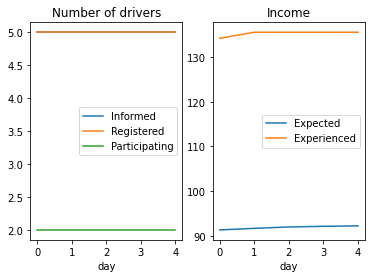

In [26]:
# Plot number of drivers and income
fig, axes = plt.subplots(nrows=1, ncols=2)
evol_stats[['regist','inform','particip']].plot(ax = axes[0])
axes[0].set_title('Number of drivers')
axes[0].legend(['Informed','Registered','Participating'])
evol_stats[['mean_perc_inc','mean_exp_inc']].plot(ax = axes[1])
axes[1].set_title('Income')
axes[1].legend(['Expected','Experienced'])

In [27]:
evol_stats

,inform,regist,particip,mean_perc_inc,mean_exp_inc
day,,,,,
0,5,5,2,91.387548,134.125287
1,5,5,2,91.743305,135.490625
2,5,5,2,92.043936,135.490625
3,5,5,2,92.194251,135.490625
4,5,5,2,92.284440,135.490625


In [36]:
inData.requests

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,platform,ride_id,position,sim_schedule
pax,,,,,,,,,,,,,,,
0,0,44786849,1530303662,2020-12-15 11:40:01,NaN,0 days 00:46:32,2020-12-15 12:26:33,NaN,False,NaN,2792,0,0,0,node time req_id od 0 ...
1,1,44763544,1608998247,2020-12-15 11:44:51,NaN,0 days 00:16:49,2020-12-15 12:01:40,NaN,False,NaN,1009,0,1,0,node time req_id od 0 ...
2,2,1774593302,44858421,2020-12-15 11:50:31,NaN,0 days 01:12:46,2020-12-15 13:03:17,NaN,False,NaN,4366,0,2,0,node time req_id od 0 ...
3,3,44739854,1519889905,2020-12-15 11:50:49,NaN,0 days 00:39:09,2020-12-15 12:29:58,NaN,False,NaN,2349,0,3,0,node time req_id od 0 ...
4,4,1608998306,1668136728,2020-12-15 11:51:00,NaN,0 days 01:05:29,2020-12-15 12:56:29,NaN,False,NaN,3929,0,4,0,node time req_id od 0 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,2374392592,3377240348,2020-12-15 19:15:48,NaN,0 days 00:37:54,2020-12-15 19:53:42,NaN,False,NaN,2274,0,195,0,node time req_id od 0 ...
196,196,44858431,44820020,2020-12-15 19:17:37,NaN,0 days 00:30:31,2020-12-15 19:48:08,NaN,False,NaN,1831,0,196,0,node time req_id od 0 NaN...
197,197,44811247,44847008,2020-12-15 19:24:11,NaN,0 days 00:18:40,2020-12-15 19:42:51,NaN,False,NaN,1120,0,197,0,node time req_id od 0 NaN...


In [37]:
sim.requests

,pax_id,origin,destination,treq,tdep,ttrav,tarr,tdrop,shareable,schedule_id,dist,platform,ride_id,position,sim_schedule
id,,,,,,,,,,,,,,,
1,0,44786849,1530303662,2020-12-15 11:40:01,NaN,0 days 00:46:32,2020-12-15 12:26:33,NaN,False,NaN,2792,0,0,0,node time req_id od 0 ...
2,1,44763544,1608998247,2020-12-15 11:44:51,NaN,0 days 00:16:49,2020-12-15 12:01:40,NaN,False,NaN,1009,0,1,0,node time req_id od 0 ...
3,2,1774593302,44858421,2020-12-15 11:50:31,NaN,0 days 01:12:46,2020-12-15 13:03:17,NaN,False,NaN,4366,0,2,0,node time req_id od 0 ...
4,3,44739854,1519889905,2020-12-15 11:50:49,NaN,0 days 00:39:09,2020-12-15 12:29:58,NaN,False,NaN,2349,0,3,0,node time req_id od 0 ...
5,4,1608998306,1668136728,2020-12-15 11:51:00,NaN,0 days 01:05:29,2020-12-15 12:56:29,NaN,False,NaN,3929,0,4,0,node time req_id od 0 ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,195,2374392592,3377240348,2020-12-15 19:15:48,NaN,0 days 00:37:54,2020-12-15 19:53:42,NaN,False,NaN,2274,0,195,0,node time req_id od 0 ...
197,196,44858431,44820020,2020-12-15 19:17:37,NaN,0 days 00:30:31,2020-12-15 19:48:08,NaN,False,NaN,1831,0,196,0,node time req_id od 0 NaN...
198,197,44811247,44847008,2020-12-15 19:24:11,NaN,0 days 00:18:40,2020-12-15 19:42:51,NaN,False,NaN,1120,0,197,0,node time req_id od 0 NaN...


In [30]:
inData.vehicles

,pos,event,shift_start,shift_end,platform,expected_income,res_wage,informed,registered
veh,,,,,,,,,
1,1435362499,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,52.865869,81.558372,True,True
2,44884122,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,80.000000,118.124001,True,True
3,1258471011,driverEvent.ENDS_SHIFT,0,86400,0,129.006006,90.191073,True,True
4,4261100545,driverEvent.ENDS_SHIFT,0,86400,0,140.532216,81.723912,True,True
5,1015968817,driverEvent.DECIDES_NOT_TO_DRIVE,0,86400,0,59.378868,96.610178,True,True


In [35]:
d2d.drivers[0]

,pos,informed,registered,out,init_perc_inc,exp_inc,new_perc_inc,worked_days
veh,,,,,,,,
1,1.435362e+09,True,True,True,52.865869,NaN,52.865869,0
2,4.488412e+07,True,True,True,80.000000,NaN,80.000000,0
3,4.485427e+07,True,True,False,128.979402,132.018475,130.498938,1
4,4.480949e+07,True,True,False,135.713600,136.232100,135.972850,1
5,1.015969e+09,True,True,True,59.378868,NaN,59.378868,0
